In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import utils
from PIL import Image

import torch
import torch.nn as nn
import torch.autograd as autograd

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


## InfoGAN

In [25]:
class infoGenerator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=64, class_num=2):
        super(infoGenerator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num
        
        self.label_embed = nn.Embedding(self.class_num, self.class_num)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(256 * (self.input_size // 4) * (self.input_size // 4)),
            nn.LeakyReLU(0.2),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        #utils.initialize_weights(self)

    def forward(self, noise, labels):
        x = torch.cat((noise, self.label_embed(labels)), -1)
        x = self.fc(x)
        x = x.view(-1, 256, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

class infoDiscriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=100, output_dim=1, input_size=64, class_num=2):
        super(infoDiscriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num
        
        self.label_embed = nn.Embedding(self.class_num, 1 * 64 * 64)

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim + self.class_num, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            #nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        #utils.initialize_weights(self)

    def forward(self, img, labels):
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        x = torch.cat((img, embed), 1)
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)
        # x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

In [26]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
infogan_generator = infoGenerator()
infogan_discriminator = infoDiscriminator()

infogan_generator.cuda()
infogan_discriminator.cuda()

# 가중치(weights) 초기화
infogan_generator.apply(weights_init_normal)
infogan_discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(infogan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(infogan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [27]:
n_epochs = 200 # 학습의 횟수(epoch) 설정
latent_dim = 100
n_classes = 2
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = infogan_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(infogan_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(infogan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(infogan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = infogan_generator(z, labels)
            save_image(generated_imgs, f"./results/infogan_dev/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.245342] [G loss: 0.251585] [Elapsed time: 22.00s]
[Epoch 1/200] [D loss: 0.244567] [G loss: 0.248944] [Elapsed time: 43.85s]
[Epoch 2/200] [D loss: 0.249678] [G loss: 0.230405] [Elapsed time: 65.39s]
[Epoch 3/200] [D loss: 0.250337] [G loss: 0.269257] [Elapsed time: 86.93s]
[Epoch 4/200] [D loss: 0.254131] [G loss: 0.255933] [Elapsed time: 108.44s]
[Epoch 5/200] [D loss: 0.236928] [G loss: 0.248172] [Elapsed time: 129.99s]
[Epoch 6/200] [D loss: 0.258347] [G loss: 0.343140] [Elapsed time: 151.63s]
[Epoch 7/200] [D loss: 0.268399] [G loss: 0.176844] [Elapsed time: 173.36s]
[Epoch 8/200] [D loss: 0.215859] [G loss: 0.256608] [Elapsed time: 195.27s]
[Epoch 9/200] [D loss: 0.210013] [G loss: 0.325047] [Elapsed time: 216.95s]
[Epoch 10/200] [D loss: 0.135401] [G loss: 0.478465] [Elapsed time: 238.84s]
[Epoch 11/200] [D loss: 0.243229] [G loss: 0.244603] [Elapsed time: 260.87s]
[Epoch 12/200] [D loss: 0.203401] [G loss: 0.263651] [Elapsed time: 282.57s]
[Epoch 13/200

[Epoch 106/200] [D loss: 0.265163] [G loss: 0.633693] [Elapsed time: 2315.61s]
[Epoch 107/200] [D loss: 0.193694] [G loss: 0.177760] [Elapsed time: 2337.28s]
[Epoch 108/200] [D loss: 0.178669] [G loss: 0.465838] [Elapsed time: 2358.82s]
[Epoch 109/200] [D loss: 0.138682] [G loss: 0.496883] [Elapsed time: 2380.42s]
[Epoch 110/200] [D loss: 0.163833] [G loss: 0.682768] [Elapsed time: 2402.07s]
[Epoch 111/200] [D loss: 0.127135] [G loss: 0.538307] [Elapsed time: 2423.60s]
[Epoch 112/200] [D loss: 0.254069] [G loss: 0.484978] [Elapsed time: 2445.21s]
[Epoch 113/200] [D loss: 0.254071] [G loss: 0.441987] [Elapsed time: 2466.85s]
[Epoch 114/200] [D loss: 0.237435] [G loss: 0.424844] [Elapsed time: 2488.36s]
[Epoch 115/200] [D loss: 0.108828] [G loss: 0.422263] [Elapsed time: 2509.89s]
[Epoch 116/200] [D loss: 0.096270] [G loss: 0.820320] [Elapsed time: 2531.39s]
[Epoch 117/200] [D loss: 0.185545] [G loss: 0.793281] [Elapsed time: 2552.98s]
[Epoch 118/200] [D loss: 0.349326] [G loss: 0.136470

In [28]:

# 모델 파라미터 저장
torch.save(infogan_generator.state_dict(), "infoGAN_dev_Generator_for_Face_Mask.pt")
torch.save(infogan_discriminator.state_dict(), "infoGAN_dev_Discriminator_for_Face_Mask.pt")
print("Model saved!")


Model saved!


In [29]:
# 생성자(generator) 초기화
infogan_generator = infoGenerator()
infogan_generator.cuda()
infogan_generator.load_state_dict(torch.load("infoGAN_dev_Generator_for_Face_Mask.pt"))
infogan_generator.eval()

infoGenerator(
  (label_embed): Embedding(2, 2)
  (fc): Sequential(
    (0): Linear(in_features=102, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=65536, bias=True)
    (4): BatchNorm1d(65536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    

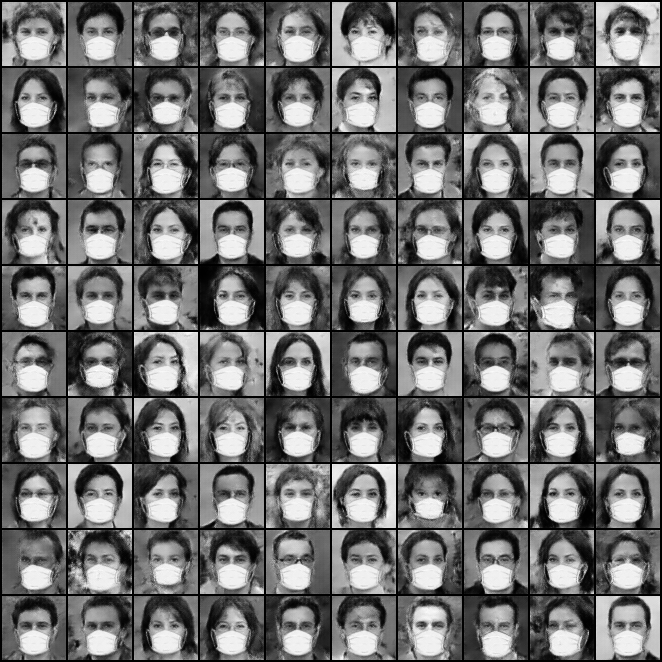

In [30]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = infogan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/infogan_dev/with_mask.png', nrow=10, normalize=True)

Display('./results/infogan_dev/with_mask.png')

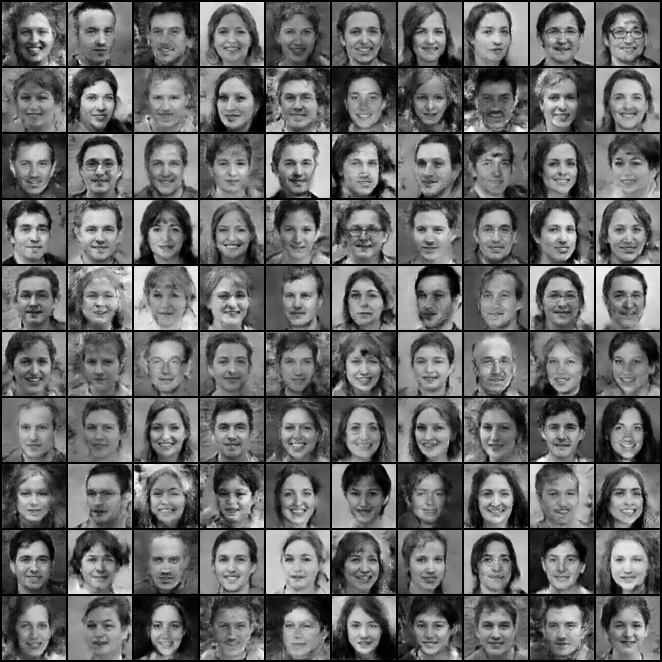

In [31]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = infogan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/infogan_dev/with_no_mask.png', nrow=10, normalize=True)

Display('./results/infogan_dev/with_no_mask.png')

In [34]:
from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = infogan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/infogan_dev/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = infogan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/infogan_dev/without_mask/{i * 100 + j}.png', normalize=True)

In [36]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/infogan_dev/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 16

Looking for images in ./results/infogan_dev/without_mask\*.png
Looking for images in ./results/infogan_dev/without_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.jpg
162.3161770145873


In [33]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/infogan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 16

Looking for images in ./results/infogan/with_mask\*.png
Looking for images in ./results/infogan/with_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.jpg
89.15576594102154
